In [1]:
import os
import time
import json
import utils
import parse
import fasttext
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

files = !ls backup*.txt


df = pd.concat(
    [utils.read_record(file) for file in files], 
    ignore_index=True)[["macroF1", "microF1", "y_pred", "y_true", "train", "eval"]]
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd' 'fasttext_dd_token_vec' 'fasttext_dd_lemma_vec'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']


# Table 2: FULL vs dedup

In [2]:
first_train = "full"
first_eval = "test_full"

second_train = "dd"
second_eval = "test_dd"

def analyze(*args, first_train=None, first_eval=None, second_train=None, second_eval=None):
    first = df[(df.train == first_train) & (df["eval"] == first_eval)]
    second = df[(df.train == second_train) & (df["eval"] == second_eval)]

    fma = first.macroF1.values
    fmi = first.microF1.values

    sma = second.macroF1.values
    smi = second.microF1.values

    def get_asterisks(p_value):
        if p < 0.001:
            return "^{***}"
        elif p < 0.01:
            return "^{**}"
        elif p < 0.05:
            return "^{*}"
        else:
            return ""
    fmamark = ""
    if fma.mean() > sma.mean():
        p = stats.mannwhitneyu(fma,sma, alternative='greater')[1]
        fmamark = get_asterisks(p)
    smamark = ""
    if fma.mean() <= sma.mean():
        p = stats.mannwhitneyu(sma, fma, alternative='greater')[1]
        smamark = get_asterisks(p)

    fmimark = ""
    if fmi.mean() > smi.mean():
        p = stats.mannwhitneyu(fmi,smi, alternative='greater')[1]
        fmimark = get_asterisks(p)
    smimark = ""
    if fmi.mean() <= smi.mean():
        p = stats.mannwhitneyu(smi, fmi, alternative='greater')[1]
        smimark = get_asterisks(p)

    print(f"""
    train on {first_train}, evaluate on {first_eval} \t & {fmi.mean():0.3} \pm {fmi.std():0.2} {fmimark} \t & {fma.mean():0.3} \pm {fma.std():0.2} {fmamark}\\\\ \cline{'{1-3}'}
    train on {second_train}, evaluate on {second_eval} \t & {smi.mean():0.3} \pm {smi.std():0.2} {smimark} \t & {sma.mean():0.3} \pm {sma.std():0.2} {smamark}\\\\ \cline{'{1-3}'}
    """)
analyze(first_train="full", first_eval="test_full", second_train="dd", second_eval="test_dd")




    train on full, evaluate on test_full 	 & 0.607 \pm 0.019  	 & 0.596 \pm 0.033 ^{*}\\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016 ^{***} 	 & 0.575 \pm 0.037 \\ \cline{1-3}
    


In [3]:
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd' 'fasttext_dd_token_vec' 'fasttext_dd_lemma_vec'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']


# XLM roberta results inclusion:

In [4]:
analyze(first_train="dd", first_eval="test_dd", second_train="xlm_dd", second_eval="test_dd")


    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 \\ \cline{1-3}
    train on xlm_dd, evaluate on test_dd 	 & 0.624 \pm 0.015  	 & 0.579 \pm 0.024 \\ \cline{1-3}
    


# Secondary labels;

In [5]:
analyze(first_train="secondary_dd", first_eval="test_dd", second_train="dd", second_eval="test_dd")


    train on secondary_dd, evaluate on test_dd 	 & 0.635 \pm 0.011  	 & 0.558 \pm 0.026 \\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 ^{*}\\ \cline{1-3}
    


# Downcasting:

In [6]:
analyze(first_train="downsampled_dd", first_eval="downsampled_test_dd", second_train="dd", second_eval="test_dd")


    train on downsampled_dd, evaluate on downsampled_test_dd 	 & 0.696 \pm 0.011 ^{***} 	 & 0.382 \pm 0.016 \\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 ^{***}\\ \cline{1-3}
    


As seen below, we first need to recalculate F1 scores:

In [7]:
df[df.train=="downsampled_dd"]

,macroF1,microF1,y_pred,y_true,train,eval
477,0.368,0.706,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
478,0.399,0.688,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
479,0.393,0.701,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
480,0.376,0.683,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
481,0.399,0.675,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
482,0.389,0.673,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
483,0.357,0.706,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
484,0.373,0.678,"[2, 2, 2, 2, 2, 2, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd
485,0.392,0.695,"[6, 6, 6, 9, 9, 9, 1, 1, 1, 6, 6, 6, 6, 6, 6, ...","[6, 6, 6, 9, 9, 9, 5, 5, 5, 6, 6, 6, 6, 6, 6, ...",downsampled_dd,downsampled_test_dd
486,0.373,0.673,"[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...","[2, 2, 2, 1, 1, 1, 9, 9, 9, 4, 4, 4, 5, 5, 5, ...",downsampled_dd,downsampled_dev_dd


In [8]:
def recalculate_f1_on_reduced(y_true, y_pred):
    y_true = utils.to_label(y_true, reduced=True)
    y_pred = utils.to_label(y_pred, reduced=True)
    mi = f1_score(y_true, y_pred, average="micro")
    ma = f1_score(y_true, y_pred, average="macro")

    return mi, ma
for i in df[df.train=="downsampled_dd"].index:
    y_true = df.loc[i, "y_true"]
    y_pred = df.loc[i, "y_pred"]

    mi, ma = recalculate_f1_on_reduced(y_true, y_pred)

    df.loc[i, "microF1"] = mi
    df.loc[i, "macroF1"] = ma


In [9]:
analyze(first_train="downsampled_dd", first_eval="downsampled_test_dd", second_train="dd", second_eval="test_dd")


    train on downsampled_dd, evaluate on downsampled_test_dd 	 & 0.696 \pm 0.011 ^{***} 	 & 0.668 \pm 0.028 ^{***}\\ \cline{1-3}
    train on dd, evaluate on test_dd 	 & 0.629 \pm 0.016  	 & 0.575 \pm 0.037 \\ \cline{1-3}
    


# Replotting figure 2 with new ordering:

```
list_categories_by_frequency = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']

list_of_categories_matrix = ['Information/Explanation','Research Article','Instruction','Recipe', 'Legal/Regulation','Call','Announcement','News/Reporting','Opinionated News','Opinion/Argumentation','Review','Promotion','Promotion of a Product','Promotion of Services','Invitation','Forum','Interview','Correspondence','Prose','List of Summaries/Excerpts','Other']


list_of_categories_matrix_donwnsampled = ['Information/Explanation','Instruction','Legal/Regulation','Announcement','News/Reporting','Opinionated News','Opinion/Argumentation','Promotion','Forum','Interview','List of Summaries/Excerpts','Other']

```

In [17]:
original = pd.read_csv("/home/peterr/macocu/task5_webgenres/data/interim/tabular_1d.csv")
length = original.shape[0]
percentages = dict()
for label in utils.train_labels_no_prefix:
    percentages[label] = len(original[original.primary==label])/length
del original

to_plot = dict()
to_plot["frequency"] = percentages
df2 = df.dropna().reset_index(drop=True)

for name, setting in zip(["40%", "60%", "80%"],["minitrain_dd", "dd", "traindev_dd"]):
    c1 = df2.train == setting
    c2 = df2["eval"] == "test_dd"
    subset = df2[c1 & c2].dropna()
    y_trues = list()
    for l in subset.y_true.values:
        y_trues.extend(utils.to_label(l))
    y_preds = list()
    for l in subset.y_pred.values:
        y_preds.extend(utils.to_label(l))
    from sklearn.metrics import f1_score
    f1s = f1_score(y_trues, y_preds, labels = utils.train_labels_no_prefix, average=None)
    current = {label: f1 for label, f1 in zip(utils.train_labels_no_prefix, f1s)}
    current 
    #macrof1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="macro")
    #current["macroF1"] = macrof1
    #microf1 = f1_score(y_trues, y_preds, labels = train_labels_no_prefix, average="micro")
    #current["microF1"] = microf1
    to_plot[name] = current

plotdf = pd.DataFrame(to_plot)
plotdf.sort_values(by="frequency", ascending=False)


,frequency,40%,60%,80%
Information/Explanation,0.130,0.720,0.710,0.736
News/Reporting,0.115,0.601,0.631,0.619
Promotion of a Product,0.115,0.693,0.689,0.690
Opinion/Argumentation,0.114,0.466,0.446,0.482
List of Summaries/Excerpts,0.106,0.710,0.709,0.725
Opinionated News,0.089,0.582,0.630,0.615
Forum,0.052,0.893,0.892,0.862
Other,0.042,0.306,0.282,0.286
Instruction,0.038,0.676,0.619,0.519
Invitation,0.032,0.568,0.547,0.575


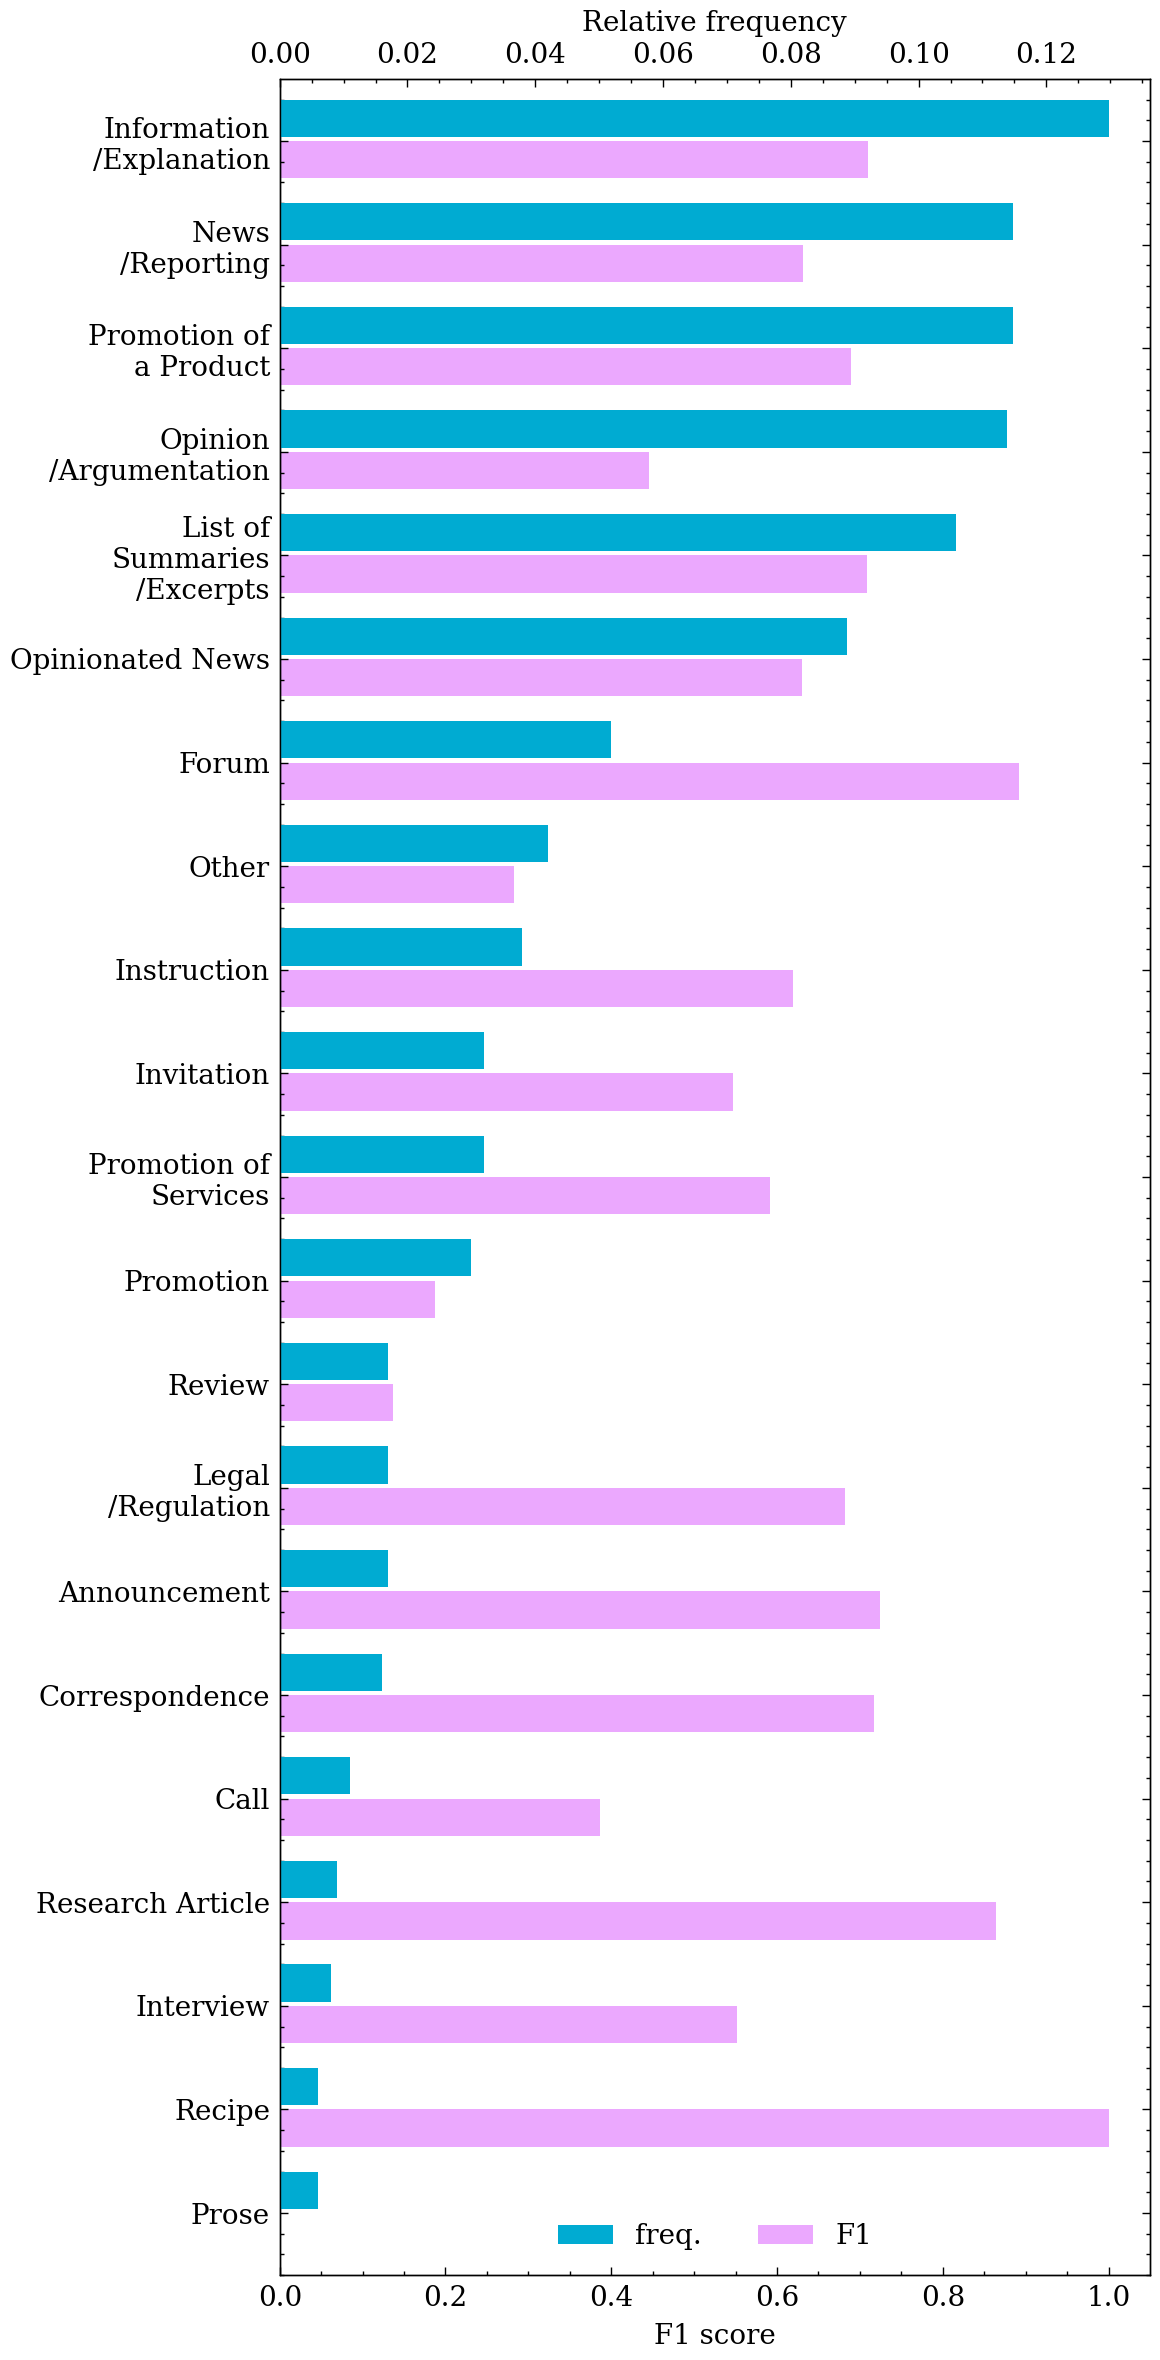

In [11]:
plotdf = pd.DataFrame(to_plot)
plotdf = plotdf.sort_values(by="frequency", ascending=False)
fig, ax = plt.subplots(figsize=(6,12), dpi=200)
ax2 = plt.twiny(ax)
spread_factor = 5
#train_labels = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']
labels = plotdf.index.values
ind = np.arange(len(labels))*spread_factor

sep = 1
height = 0.9
height *= 2
lines = list()

colors = [
    "#f1c76b",
    "#eba8fe",
    "#67e3a9",
    "#00abd2"
    ]



lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

for i, col in enumerate(["40%", "60%", "80%"]):
    if i in {0,2}:
        continue

    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, 
                        label="F1", #label=col, 
                        color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels([label.replace("/", "\n/").replace(" of ", " of\n") for label in labels], #fontsize="x-small"
                    )
ax.invert_yaxis()
ax.set_xlabel("F1 score")


ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, 
        # fontsize="x-small",
        ncol=2, loc=8)
ax.set_ylim(102, -4)

plt.tight_layout()
plt.savefig("paper/Q3_2_at_60.png")
plt.savefig("paper/Q3_2_at_60.pdf")
plt.show()


# Scatterplot for micro and macro  F1

In [12]:
percentages = [0.4, 0.6, 0.8]
macro_means = list()
macro_stds = list()
micro_means = list()
micro_stds = list()


for condition in ['minitrain_dd', "dd", 'traindev_dd']:

    c1 = df.train == condition
    c2 = df["eval"] == "test_dd"
    import numpy as np
    subset = df[c1 & c2].copy()
    micros = subset.microF1.values
    macros = subset.macroF1.values
    micro_means.append(micros.mean())
    macro_means.append(macros.mean())

    micro_stds.append(micros.std())
    macro_stds.append(macros.std())

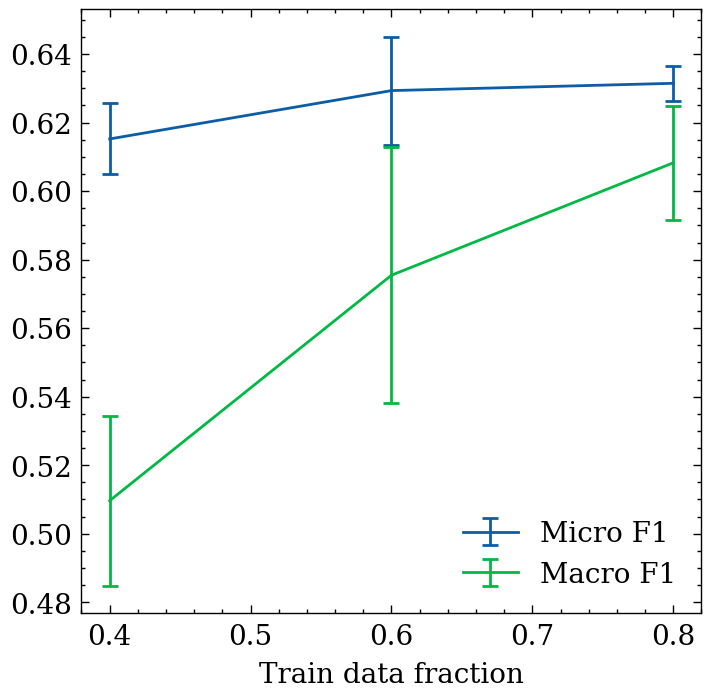

In [13]:
fig, ax = plt.subplots(figsize=(4,4), dpi=200)
ax.errorbar(percentages, micro_means, yerr=micro_stds, label="Micro F1", capsize=3)
ax.errorbar(percentages, macro_means, yerr=macro_stds, label="Macro F1", capsize=3)
ax.legend(loc="lower right")
ax.set_xlabel("Train data fraction")
#ax.set_ylim((0, 1))
#plt.savefig("paper/train_size.pdf")
#plt.savefig("paper/train_size.png")
plt.show()

# Replotting Confusion matrices

Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd' 'fasttext_dd_token_vec' 'fasttext_dd_lemma_vec'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']
microF1=0.6751
macroF1=0.6222


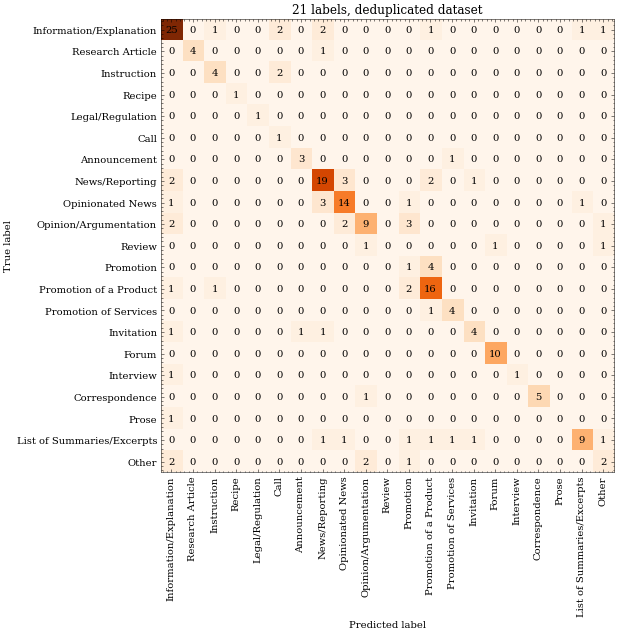

microF1=0.6751
macroF1=0.6222


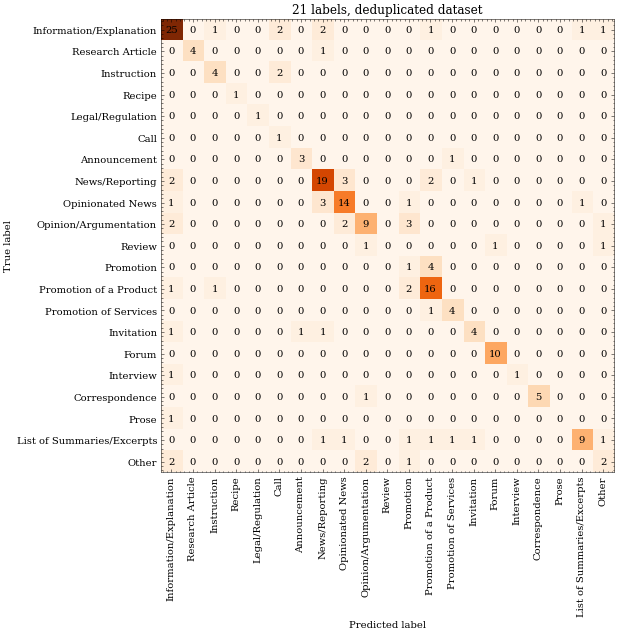

(0.6751269035532995, 0.6222073034702433)

In [14]:
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

# Part 1: best dd, test_dd model:
c1 = df.train == "dd"
c2 = df["eval"] == "test_dd"

df[c1 & c2].sort_values("microF1", ascending=False)[0:3]
# DF was inspected and the optimal i was found:
i = 305 # or 183, 413

y_true = df.loc[i, "y_true"]
y_pred = df.loc[i, "y_pred"]

y_true = utils.to_label(y_true)
y_pred = utils.to_label(y_pred)

utils.plot_cm(y_true, y_pred, labels=utils.list_of_categories_matrix, save="paper/CM_full_labels_2.png",
include_metrics=False,
title = "21 labels, deduplicated dataset")
utils.plot_cm(y_true, y_pred, labels=utils.list_of_categories_matrix, save="paper/CM_full_labels_2.pdf",
include_metrics=False,
title = "21 labels, deduplicated dataset")


Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd' 'fasttext_dd_token_vec' 'fasttext_dd_lemma_vec'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']
microF1=0.7056
macroF1=0.6439


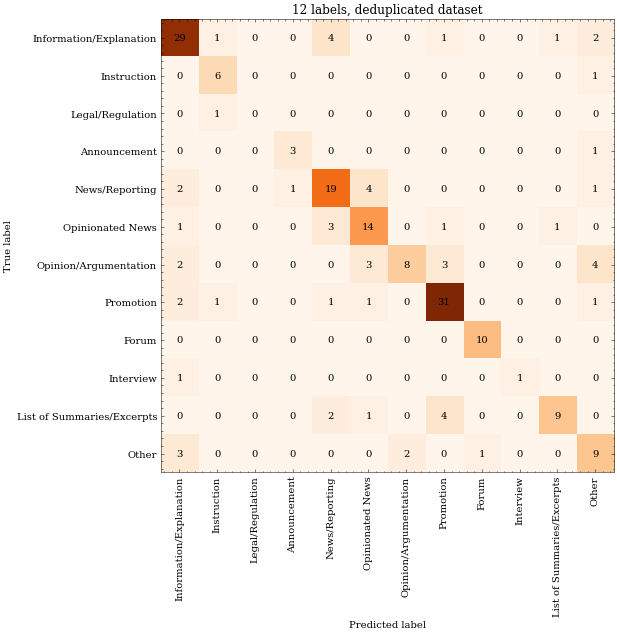

microF1=0.7056
macroF1=0.6439


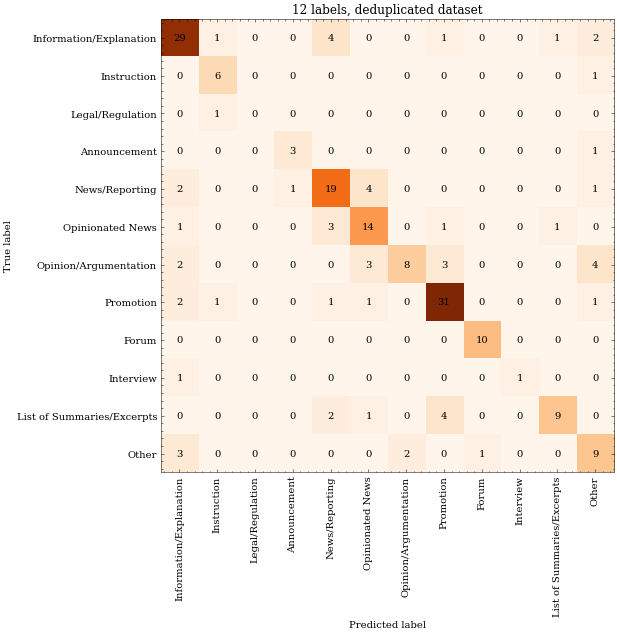

(0.7055837563451777, 0.6439148459839296)

In [15]:
# Part 2: downsampled labels

print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

c1 = df.train == "downsampled_dd"
c2 = df["eval"] == "downsampled_test_dd"

df[c1 & c2].sort_values("microF1", ascending=False)[0:3]
# DF was inspected and the optimal i was found:
i =  477 # 477, 483, 479

y_true = df.loc[i, "y_true"]
y_pred = df.loc[i, "y_pred"]

y_true = utils.to_label(y_true, reduced=True)
y_pred = utils.to_label(y_pred, reduced=True)

utils.plot_cm(y_true, y_pred, labels=utils.list_of_categories_matrix_donwnsampled, save="paper/CM_downsampled_labels_2.png",
include_metrics=False,
title = "12 labels, deduplicated dataset")
utils.plot_cm(y_true, y_pred, labels=utils.list_of_categories_matrix_donwnsampled, save="paper/CM_downsampled_labels_2.pdf",
include_metrics=False,
title = "12 labels, deduplicated dataset")


# Training fasttext models

In [16]:
import os
import parse
import fasttext
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import utils
datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext2"

test_dd = os.path.join(datadir, "test_onlyprimary_True_dedup_True.fasttext")
train_dd = os.path.join(datadir, "train_onlyprimary_True_dedup_True.fasttext")

def parse_test_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    return labels, texts

def prediction_to_label(prediction):
    """Transforms predicitons as returned by fasttext into pure labels."""
    import numpy as np
    return np.array(prediction[0])[:, 0]

def plot_cm(y_true, y_pred, labels, save=False, title=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred, labels=labels, )
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    classNames = labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    microF1 = f1_score(y_true, y_pred, labels=labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=labels, average ="macro")

    print(f"{microF1=:0.4}")
    print(f"{macroF1=:0.4}")

    metrics = f"{microF1=:0.4}, {macroF1=:0.4}"
    if title:
        plt.title(title +";\n" + metrics)
    else:
        plt.title(metrics)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()
    return microF1, macroF1


all_labels = utils.train_labels
results = list()
for i in range(10):
    model = fasttext.train_supervised(input=train_dd, 
                                            #autotuneValidationFile=dev_full, 
                                            #autotuneDuration=60*15
                                            epoch=200,
                                            #dim=100,
        pretrainedVectors="/home/peterr/macocu/task5_webgenres/fasttext_embeddings/embed.sl-lemma.ft.sg.vec"
                                            )
    y_true, texts = parse_test_file(test_dd)
    y_pred = model.predict(texts)
    y_pred = prediction_to_label(y_pred)

    m, M = plot_cm(y_true, y_pred, all_labels, save=False, title=f"")
    rezdict = dict(
        microF1=m,
        macroF1=M,
        y_true= y_true,
        y_pred=y_pred,
        train="fasttext_dd_lemma_vec",
        eval="test_dd"
    )
    results.append(rezdict)
with open("backup_24_2.txt", "w") as f:
    import json
    for i in results:
        i["y_pred"] = i["y_pred"].tolist()
    json.dump(results, f)

ValueError: /home/peterr/macocu/task5_webgenres/fasttext_embeddings/embed.sl-lemma.ft.sg.vec cannot be opened for loading!

In [ ]:
import os
import time
import json
import utils
import parse
import fasttext
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
plt.style.use(["science", "no-latex"])

files = !ls backup*.txt


df = pd.concat(
    [utils.read_record(file) for file in files], 
    ignore_index=True)[["macroF1", "microF1", "y_pred", "y_true", "train", "eval"]]
print("Train values:", df.train.unique(), "\neval values:",df["eval"].unique())

def analyze(*args, first_train=None, first_eval=None, second_train=None, second_eval=None):
    first = df[(df.train == first_train) & (df["eval"] == first_eval)]
    second = df[(df.train == second_train) & (df["eval"] == second_eval)]

    fma = first.macroF1.values
    fmi = first.microF1.values

    sma = second.macroF1.values
    smi = second.microF1.values

    def get_asterisks(p_value):
        if p < 0.001:
            return "^{***}"
        elif p < 0.01:
            return "^{**}"
        elif p < 0.05:
            return "^{*}"
        else:
            return ""
    fmamark = ""
    if fma.mean() > sma.mean():
        p = stats.mannwhitneyu(fma,sma, alternative='greater')[1]
        fmamark = get_asterisks(p)
    smamark = ""
    if fma.mean() <= sma.mean():
        p = stats.mannwhitneyu(sma, fma, alternative='greater')[1]
        smamark = get_asterisks(p)

    fmimark = ""
    if fmi.mean() > smi.mean():
        p = stats.mannwhitneyu(fmi,smi, alternative='greater')[1]
        fmimark = get_asterisks(p)
    smimark = ""
    if fmi.mean() <= smi.mean():
        p = stats.mannwhitneyu(smi, fmi, alternative='greater')[1]
        smimark = get_asterisks(p)

    print(f"""
    train on {first_train}, evaluate on {first_eval} \t & {fmi.mean():0.3} \pm {fmi.std():0.2} {fmimark} \t & {fma.mean():0.3} \pm {fma.std():0.2} {fmamark}\\\\ \cline{'{1-3}'}
    train on {second_train}, evaluate on {second_eval} \t & {smi.mean():0.3} \pm {smi.std():0.2} {smimark} \t & {sma.mean():0.3} \pm {sma.std():0.2} {smamark}\\\\ \cline{'{1-3}'}
    """)
analyze(first_train="fasttext_dd_lemma_vec", first_eval="test_dd", second_train='fasttext_dd_token_vec', second_eval="test_dd")


Train values: ['ok' 'full' 'dd' 'OK' 'secondary_dd' 'traindev_dd' 'minitrain_dd'
 'downsampled_dd' 'xlm_dd' 'fasttext_dd_token_vec' 'fasttext_dd_lemma_vec'] 
eval values: ['test_full' 'test_dd' 'dev_full' 'dev_dd' 'devtest_full' 'devtest_dd'
 'downsampled_test_dd' 'downsampled_dev_dd']

    train on fasttext_dd_lemma_vec, evaluate on test_dd 	 & 0.259 \pm 0.0075  	 & 0.147 \pm 0.0056 \\ \cline{1-3}
    train on fasttext_dd_token_vec, evaluate on test_dd 	 & 0.361 \pm 0.0071 ^{***} 	 & 0.219 \pm 0.013 ^{***}\\ \cline{1-3}
    


# Replotting for SSS

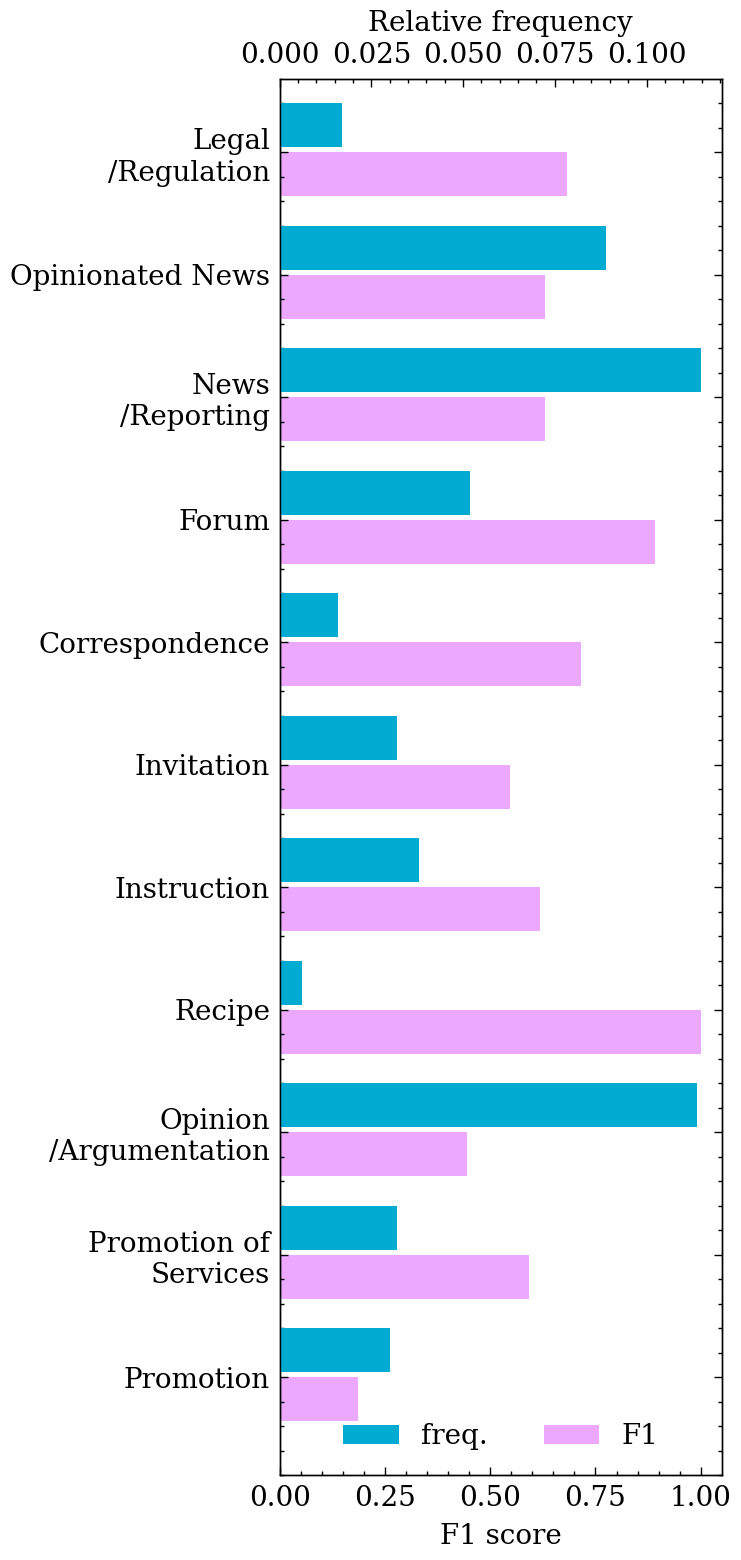

In [28]:
plotdf = pd.DataFrame(to_plot)
plotdf = plotdf.sort_values(by="frequency", ascending=False)
plotdf = plotdf.loc[['Legal/Regulation', 'Opinionated News', 'News/Reporting', 'Forum',
       'Correspondence', 'Invitation', 'Instruction', 'Recipe',
       'Opinion/Argumentation', 'Promotion of Services', 'Promotion'], :]
fig, ax = plt.subplots(figsize=(4,8), dpi=200)
ax2 = plt.twiny(ax)
spread_factor = 5
#train_labels = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']
labels = plotdf.index.values
ind = np.arange(len(plotdf.index))*spread_factor

sep = 1
height = 0.9
height *= 2
lines = list()

colors = [
    "#f1c76b",
    "#eba8fe",
    "#67e3a9",
    "#00abd2"
    ]



lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

for i, col in enumerate(["40%", "60%", "80%"]):
    if i in {0,2}:
        continue

    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, 
                        label="F1", #label=col, 
                        color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels([label.replace("/", "\n/").replace(" of ", " of\n") for label in labels], #fontsize="x-small"
                    )
ax.invert_yaxis()
ax.set_xlabel("F1 score")


ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, 
        # fontsize="x-small",
        ncol=2, loc=8)
ax.set_ylim(53, -4)

plt.tight_layout()
plt.savefig("paper/Q3_2_at_60_part_1.png")
plt.savefig("paper/Q3_2_at_60_part_1.pdf")
plt.show()


In [29]:
plotdf

,frequency,40%,60%,80%
Legal/Regulation,0.017,0.333,0.683,0.833
Opinionated News,0.089,0.582,0.630,0.615
News/Reporting,0.115,0.601,0.631,0.619
Forum,0.052,0.893,0.892,0.862
Correspondence,0.016,0.489,0.717,0.566
Invitation,0.032,0.568,0.547,0.575
Instruction,0.038,0.676,0.619,0.519
Recipe,0.006,1.000,1.000,1.000
Opinion/Argumentation,0.114,0.466,0.446,0.482
Promotion of Services,0.032,0.533,0.591,0.694


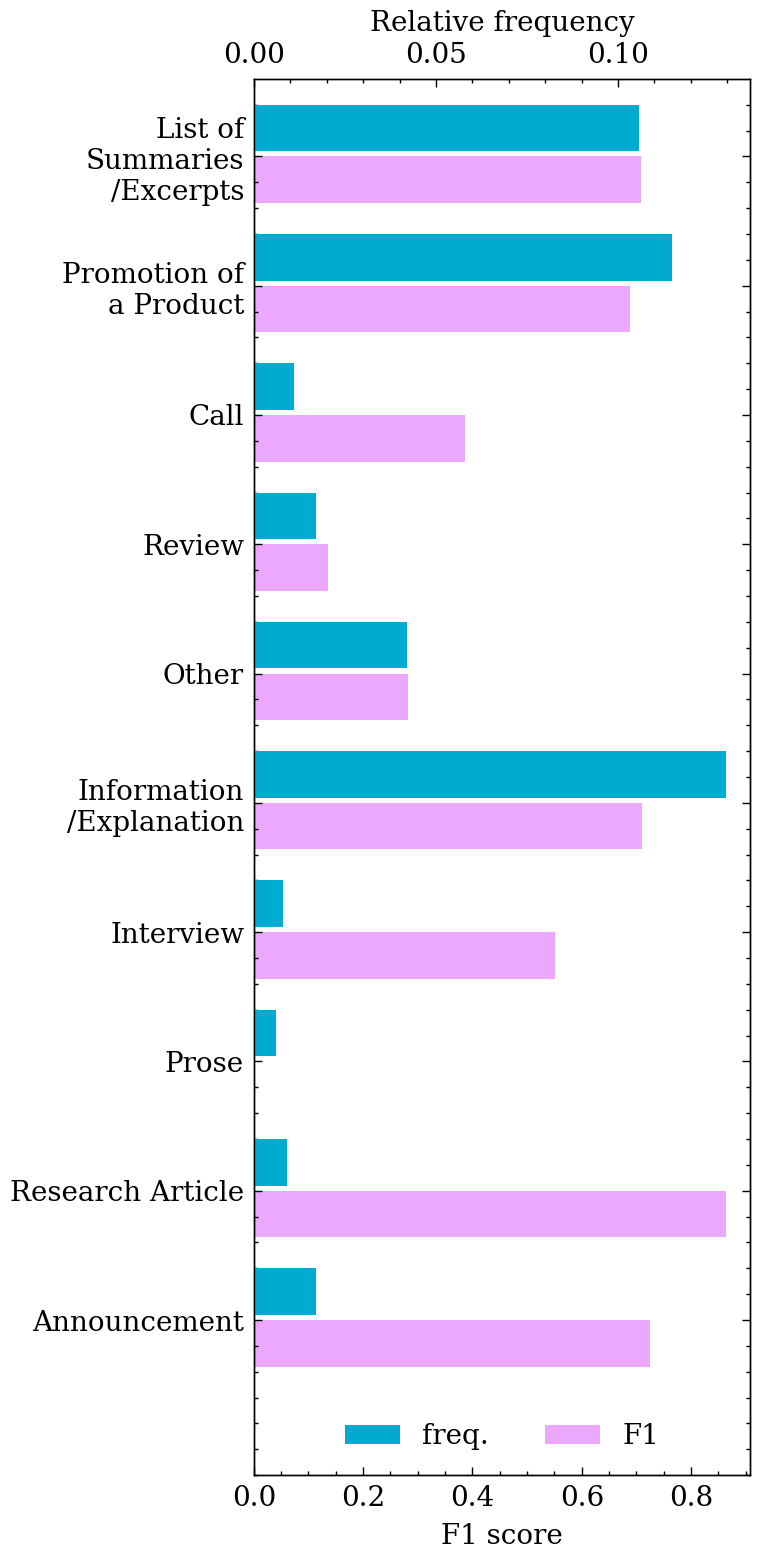

In [26]:
plotdf = pd.DataFrame(to_plot)
plotdf = plotdf.sort_values(by="frequency", ascending=False)
plotdf = plotdf.loc[['List of Summaries/Excerpts', 'Promotion of a Product', 'Call',
       'Review', 'Other', 'Information/Explanation', 'Interview', 'Prose',
       'Research Article', 'Announcement'], :]
fig, ax = plt.subplots(figsize=(4,8), dpi=200)
ax2 = plt.twiny(ax)
spread_factor = 5
#train_labels = ['Information/Explanation', 'News/Reporting', 'Promotion of a Product', 'Opinion/Argumentation', 'List of Summaries/Excerpts', 'Opinionated News', 'Forum', 'Instruction', 'Other', 'Promotion of Services', 'Invitation', 'Promotion', 'Legal/Regulation', 'Announcement', 'Review', 'Correspondence', 'Call', 'Research Article', 'Interview', 'Recipe', 'Prose']
labels = plotdf.index.values
ind = np.arange(len(plotdf.index))*spread_factor

sep = 1
height = 0.9
height *= 2
lines = list()

colors = [
    "#f1c76b",
    "#eba8fe",
    "#67e3a9",
    "#00abd2"
    ]



lines.append(ax2.barh(ind-3*sep, plotdf["frequency"].values, 
        height=height, 
        label="freq.", 
        color=colors[-1],
        align="edge"))

for i, col in enumerate(["40%", "60%", "80%"]):
    if i in {0,2}:
        continue

    lines.append(ax.barh(ind+(i-2)*sep, plotdf[col].values, height=height, 
                        label="F1", #label=col, 
                        color=colors[i],
    align = "edge"))
ax.set_yticks(ind-1*sep)
ax.set_yticklabels([label.replace("/", "\n/").replace(" of ", " of\n") for label in labels], #fontsize="x-small"
                    )
ax.invert_yaxis()
ax.set_xlabel("F1 score")


ax2.set_xlabel("Relative frequency")

labs = [l.get_label() for l in lines]
ax.legend(lines, labs, 
        # fontsize="x-small",
        ncol=2, loc=8)
ax.set_ylim(50, -4)

plt.tight_layout()
plt.savefig("paper/Q3_2_at_60_part_2.png")
plt.savefig("paper/Q3_2_at_60_part_2.pdf")
plt.show()
